# Прогнозирование распространение COVID-19 в России

Прогностические модели пытаются предсказать будущие значения на основе исторических данных. В этом практическом проекте мы проанализируем распространение вируса Ковид-19 и обучим модель временных рядов (fbprophet) для получения прогноза случаев заболевания, связанных с коронавирусом, в России. Данные были взяты из сайта [Kaggle](https://www.kaggle.com/kapral42/covid19-russia-regions-cases/version/117). В этом практическом проекте мы выполним следующие этапы:
* Импорт наборов данных и библиотек
* Проводим разведочный анализ данных
* Выполняем визуализацию данных
* Подготавливаем данные для загрузки в модель fbprophet
* Обучаем модель fbprophet
* Оценка эффективности модели

### Импорт наборов данных и библиотек

In [29]:
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from fbprophet import Prophet
from sklearn.metrics import r2_score
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
import plotly.io as pio
pio.renderers.default = 'notebook'

In [30]:
# Day-Confirmed - Подтвержденные случаи ковида за день
# Day-Deaths - Смертельные случаи за день
# Day-Recovered - Случаи восстановленния от ковида за день
# Confirmed - Подтвержденные случаи ковида в сумме
# Deaths - Смертельные случаи в сумме
# Recovered - Случаи восстановленния от ковида в сумме
df = pd.read_csv('data.csv')
df

,Date,Region/City,Region/City-Eng,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
0,2020-03-02,Московская область,Moscow region,50.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2020-03-03,Московская область,Moscow region,50.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2020-03-04,Московская область,Moscow region,50.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2020-03-05,Московская область,Moscow region,50.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2020-03-06,Москва,Moscow,77.0,5.0,0.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12049,2020-07-31,Ханты-Мансийский АО,Khanty-Mansiysk,86.0,171.0,0.0,338.0,16333.0,128.0,12790.0
12050,2020-07-31,Челябинская область,Chelyabinsk region,74.0,117.0,1.0,251.0,11197.0,93.0,6686.0
12051,2020-07-31,Чеченская Республика,Chechen Republic,95.0,14.0,0.0,6.0,2060.0,32.0,1363.0
12052,2020-07-31,Ямало-Ненецкий АО,Yamalo-Nenets Autonomous Okrug,89.0,112.0,0.0,392.0,11016.0,77.0,8023.0


### Проводим разведочный анализ данных

In [31]:
# Получаем информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12054 entries, 0 to 12053
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             12054 non-null  object 
 1   Region/City      12054 non-null  object 
 2   Region/City-Eng  12054 non-null  object 
 3   Region_ID        12054 non-null  float64
 4   Day-Confirmed    12054 non-null  float64
 5   Day-Deaths       12054 non-null  float64
 6   Day-Recovered    12054 non-null  float64
 7   Confirmed        12054 non-null  float64
 8   Deaths           12054 non-null  float64
 9   Recovered        12054 non-null  float64
dtypes: float64(7), object(3)
memory usage: 941.8+ KB


In [32]:
# Статистические данные датафрейма
df.describe()

,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
count,12054.000000,12054.000000,12054.000000,12054.000000,12054.000000,12054.000000,12054.000000
mean,44.055998,69.684835,1.158371,52.962585,4047.030695,56.001327,2294.345694
std,25.387604,262.131768,5.137943,220.031198,17612.915566,302.597806,11027.328842
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,4.000000,0.000000,0.000000,53.000000,0.000000,6.000000
50%,44.000000,32.000000,0.000000,10.000000,1018.000000,7.000000,329.000000
75%,65.000000,69.000000,1.000000,47.000000,3589.250000,28.000000,2031.500000
max,95.000000,6703.000000,78.000000,8033.000000,241359.000000,4460.000000,179168.000000


In [33]:
# Сортировка датафрейма по дате
df.sort_values(by = "Date")

,Date,Region/City,Region/City-Eng,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
0,2020-03-02,Московская область,Moscow region,50.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2020-03-03,Московская область,Moscow region,50.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2020-03-04,Московская область,Moscow region,50.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2020-03-05,Московская область,Moscow region,50.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2020-03-06,Москва,Moscow,77.0,5.0,0.0,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11993,2020-07-31,Красноярский край,Krasnoyarsk region,24.0,145.0,6.0,84.0,13145.0,331.0,11710.0
11992,2020-07-31,Краснодарский край,Krasnodar region,23.0,96.0,3.0,131.0,8266.0,113.0,7131.0
11991,2020-07-31,Костромская область,Kostroma region,44.0,31.0,0.0,56.0,2206.0,26.0,1677.0
11999,2020-07-31,Москва,Moscow,77.0,695.0,14.0,1260.0,241359.0,4460.0,179168.0


In [34]:
# Выведим количество городов/регионов в датафрейме 
print("Итоговое количество городов/регионов:", len(df["Region/City"].unique()))

Итоговое количество городов/регионов: 85


### Выполняем визуализацию данных

In [35]:
# Функция для построения интерактивного графика

def interactive_plot(df, column_name, title):
    fig = px.line(title = title,width=2000, height=1000)
    for i in df["Region/City"].unique():
        d = df[df["Region/City"] == i]
        fig.add_scatter(x = d["Date"], y = d[column_name], name = i)
    fig.show("png")

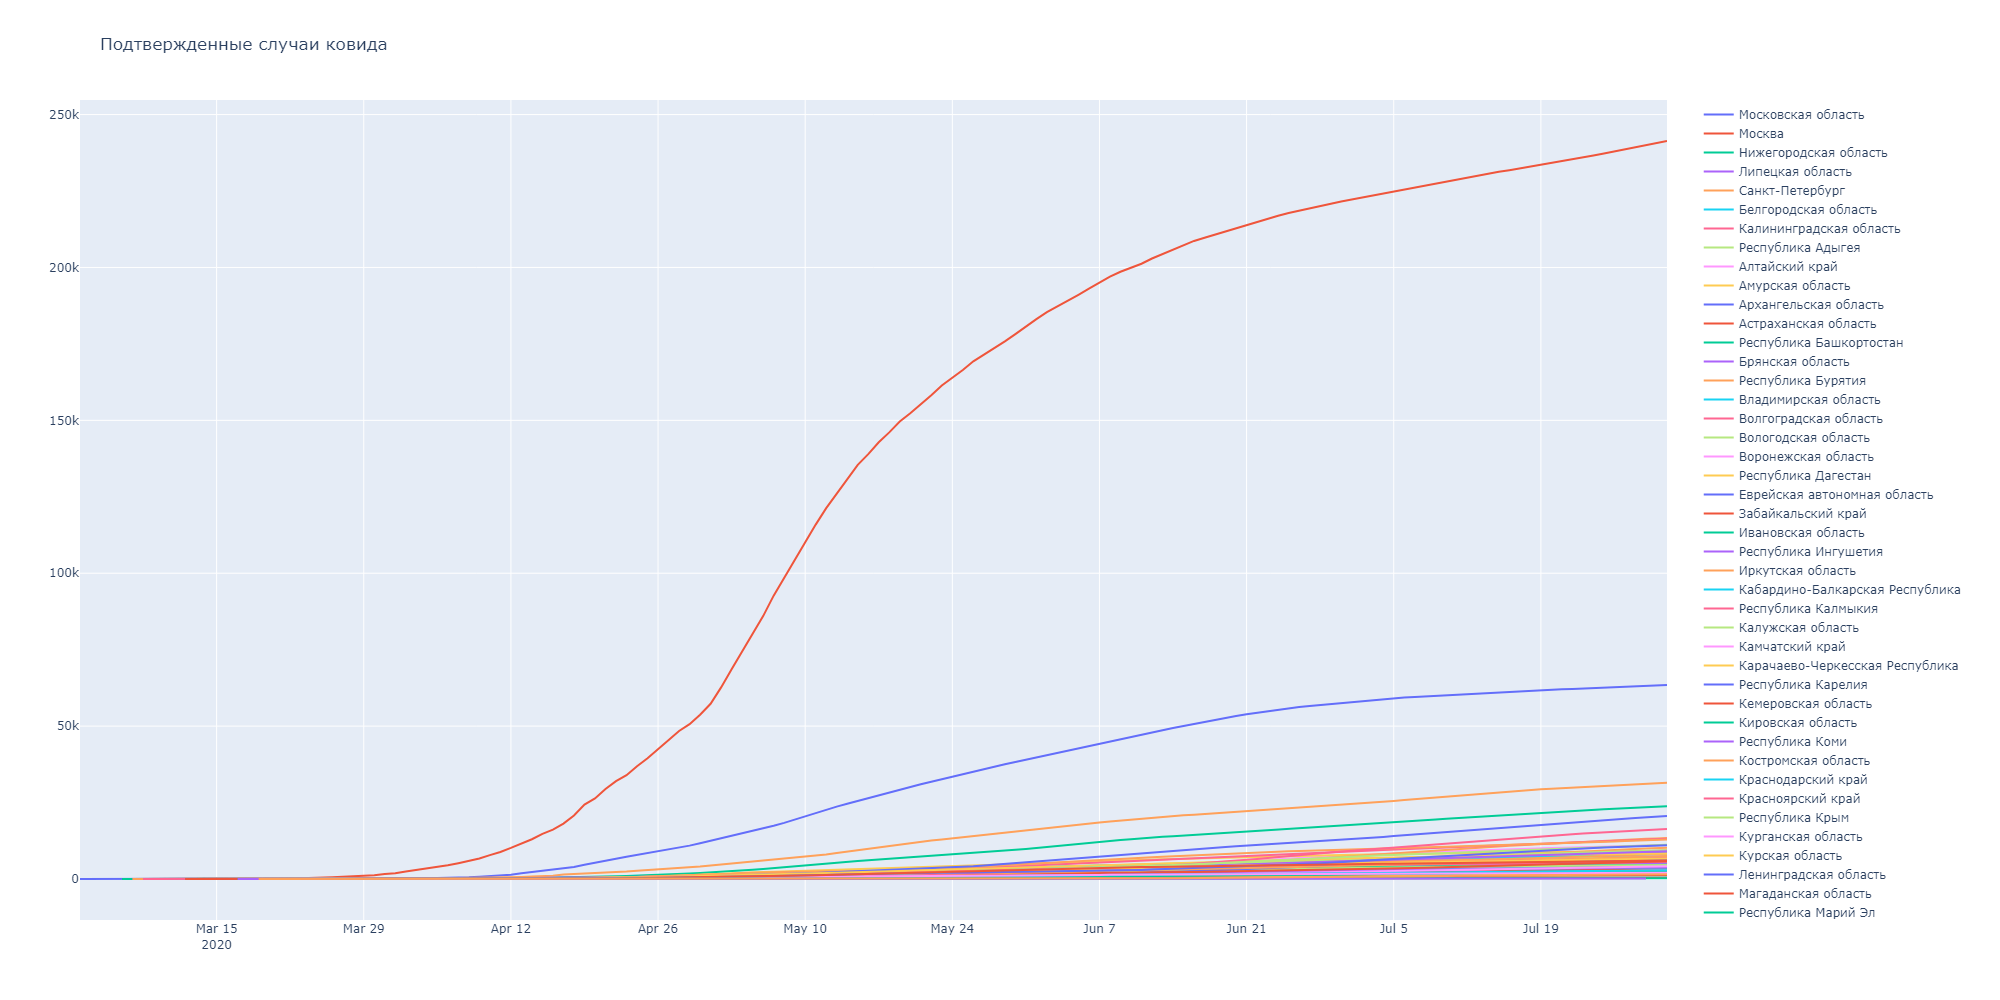

In [36]:
# Строим интерактивную диаграмму
interactive_plot(df, "Confirmed", "Подтвержденные случаи ковида")

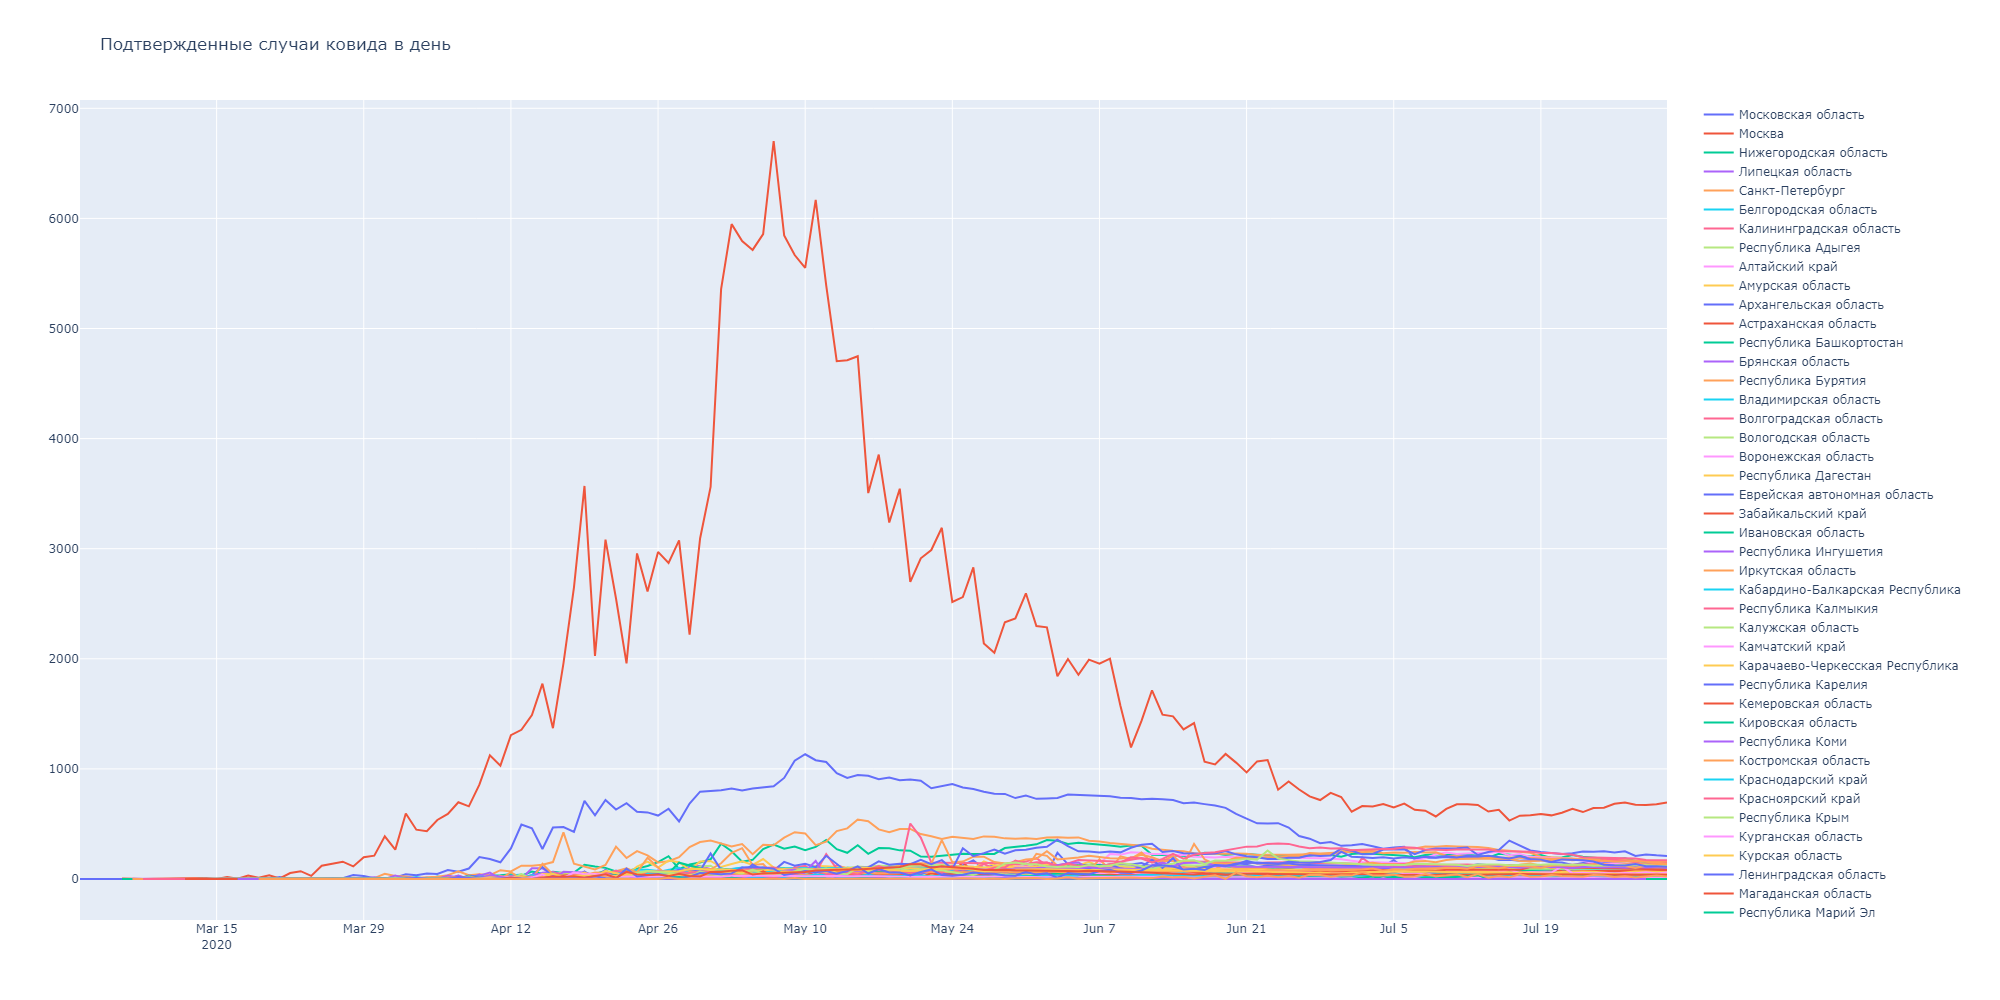

In [37]:
# Строим интерактивную диаграмму
interactive_plot(df, "Day-Confirmed", "Подтвержденные случаи ковида в день")

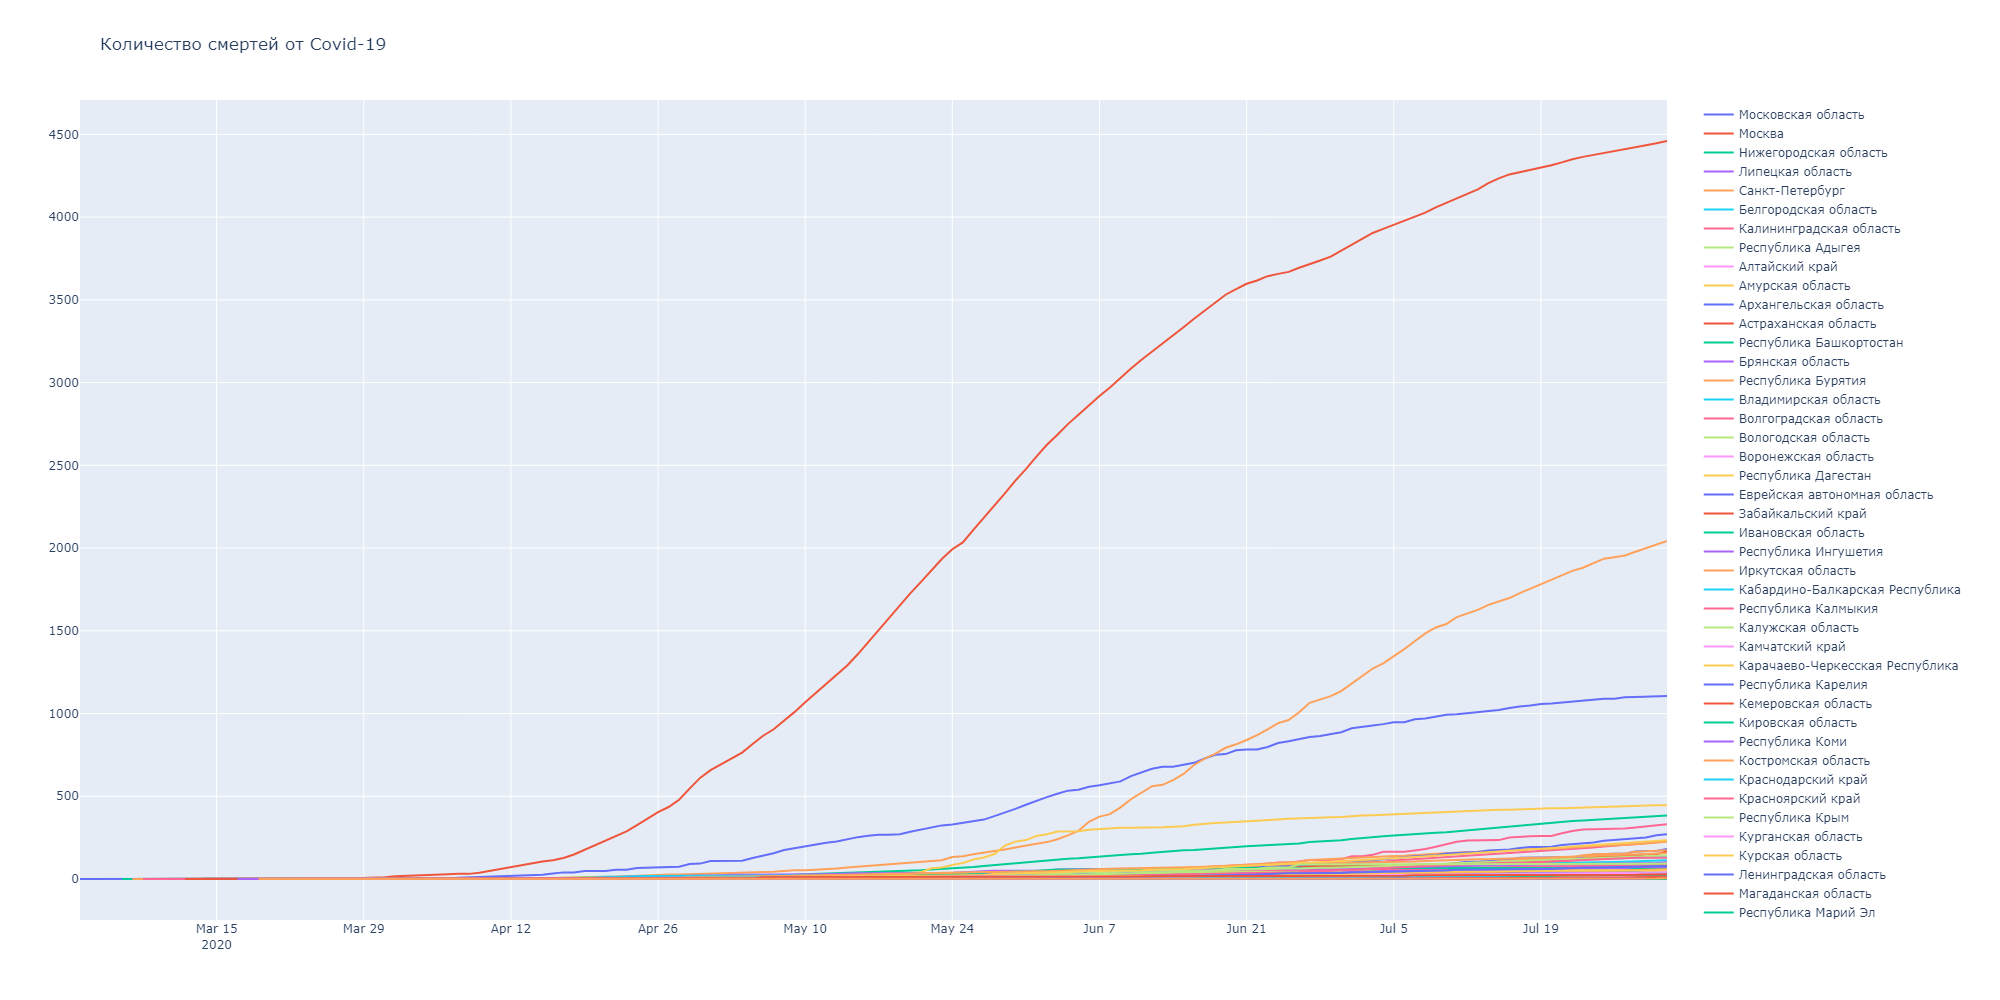

In [38]:
# Строим интерактивную диаграмму
interactive_plot(df, "Deaths", "Количество смертей от Covid-19")

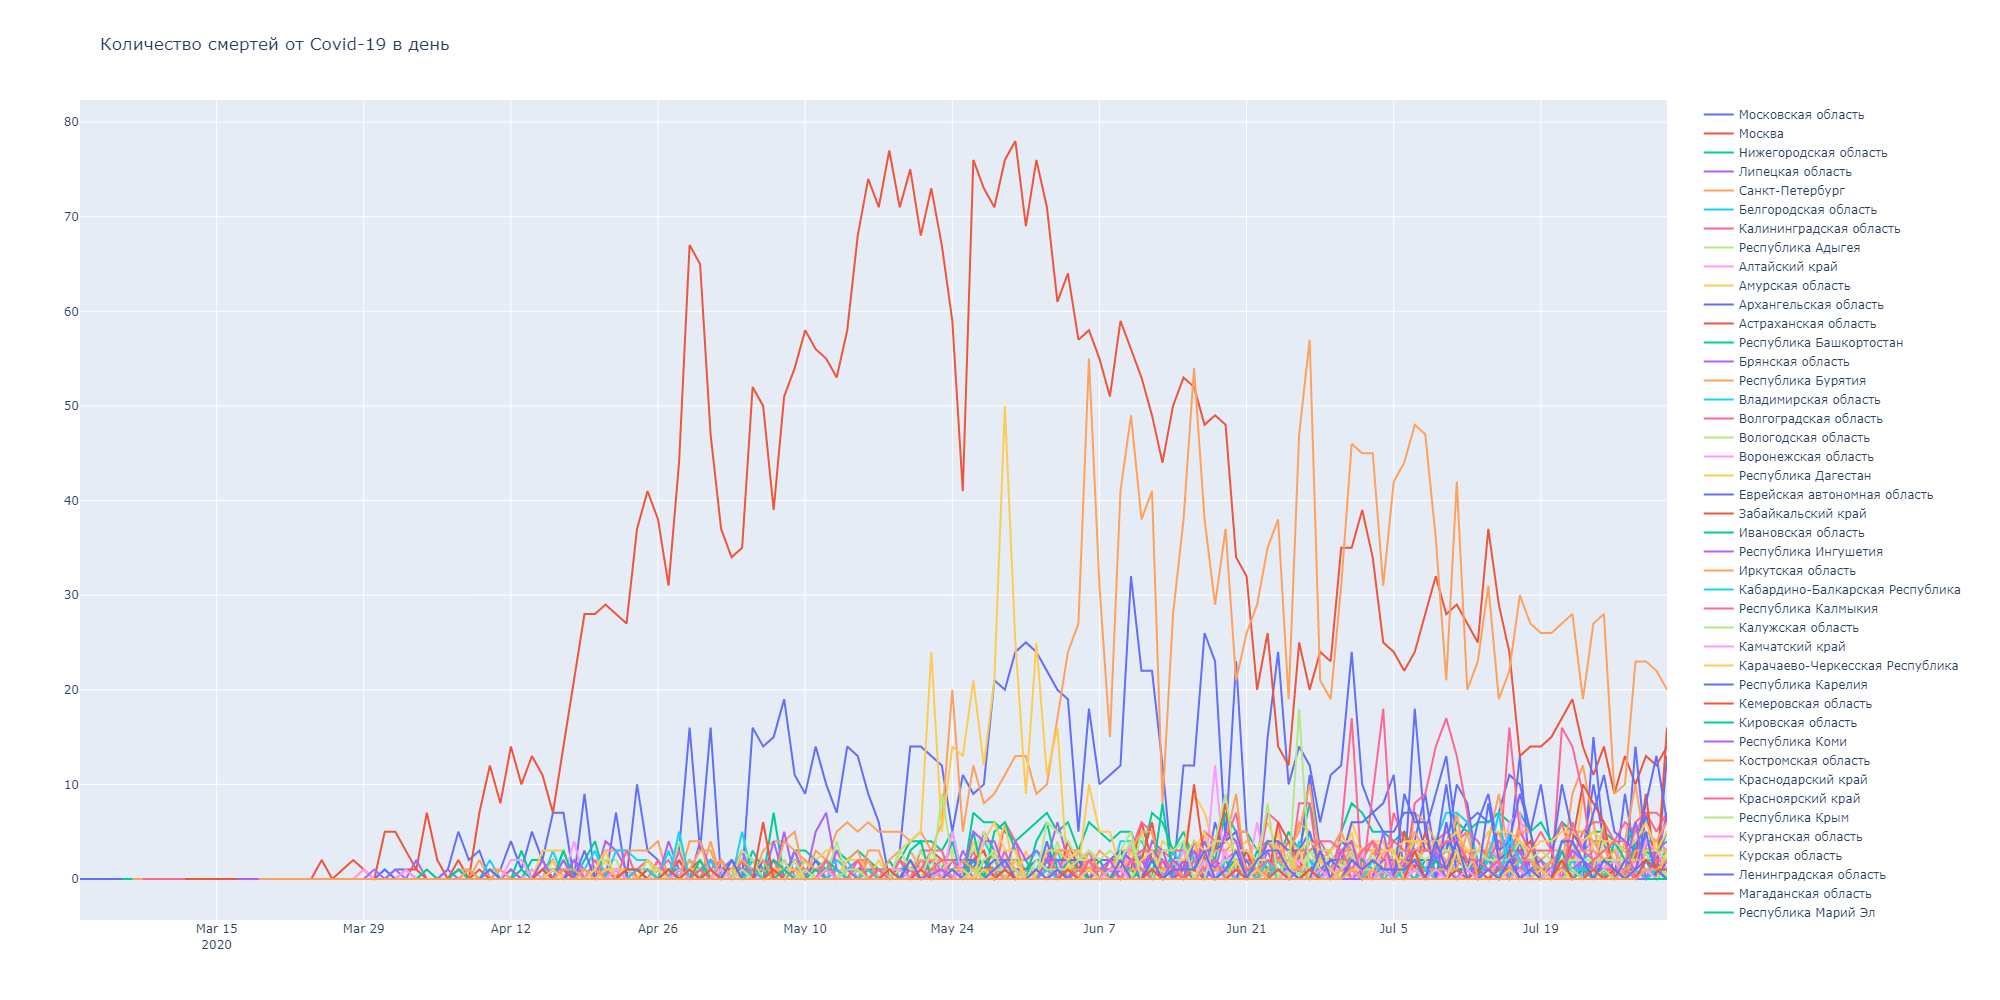

In [39]:
# Строим интерактивную диаграмму
interactive_plot(df, "Day-Deaths", "Количество смертей от Covid-19 в день")

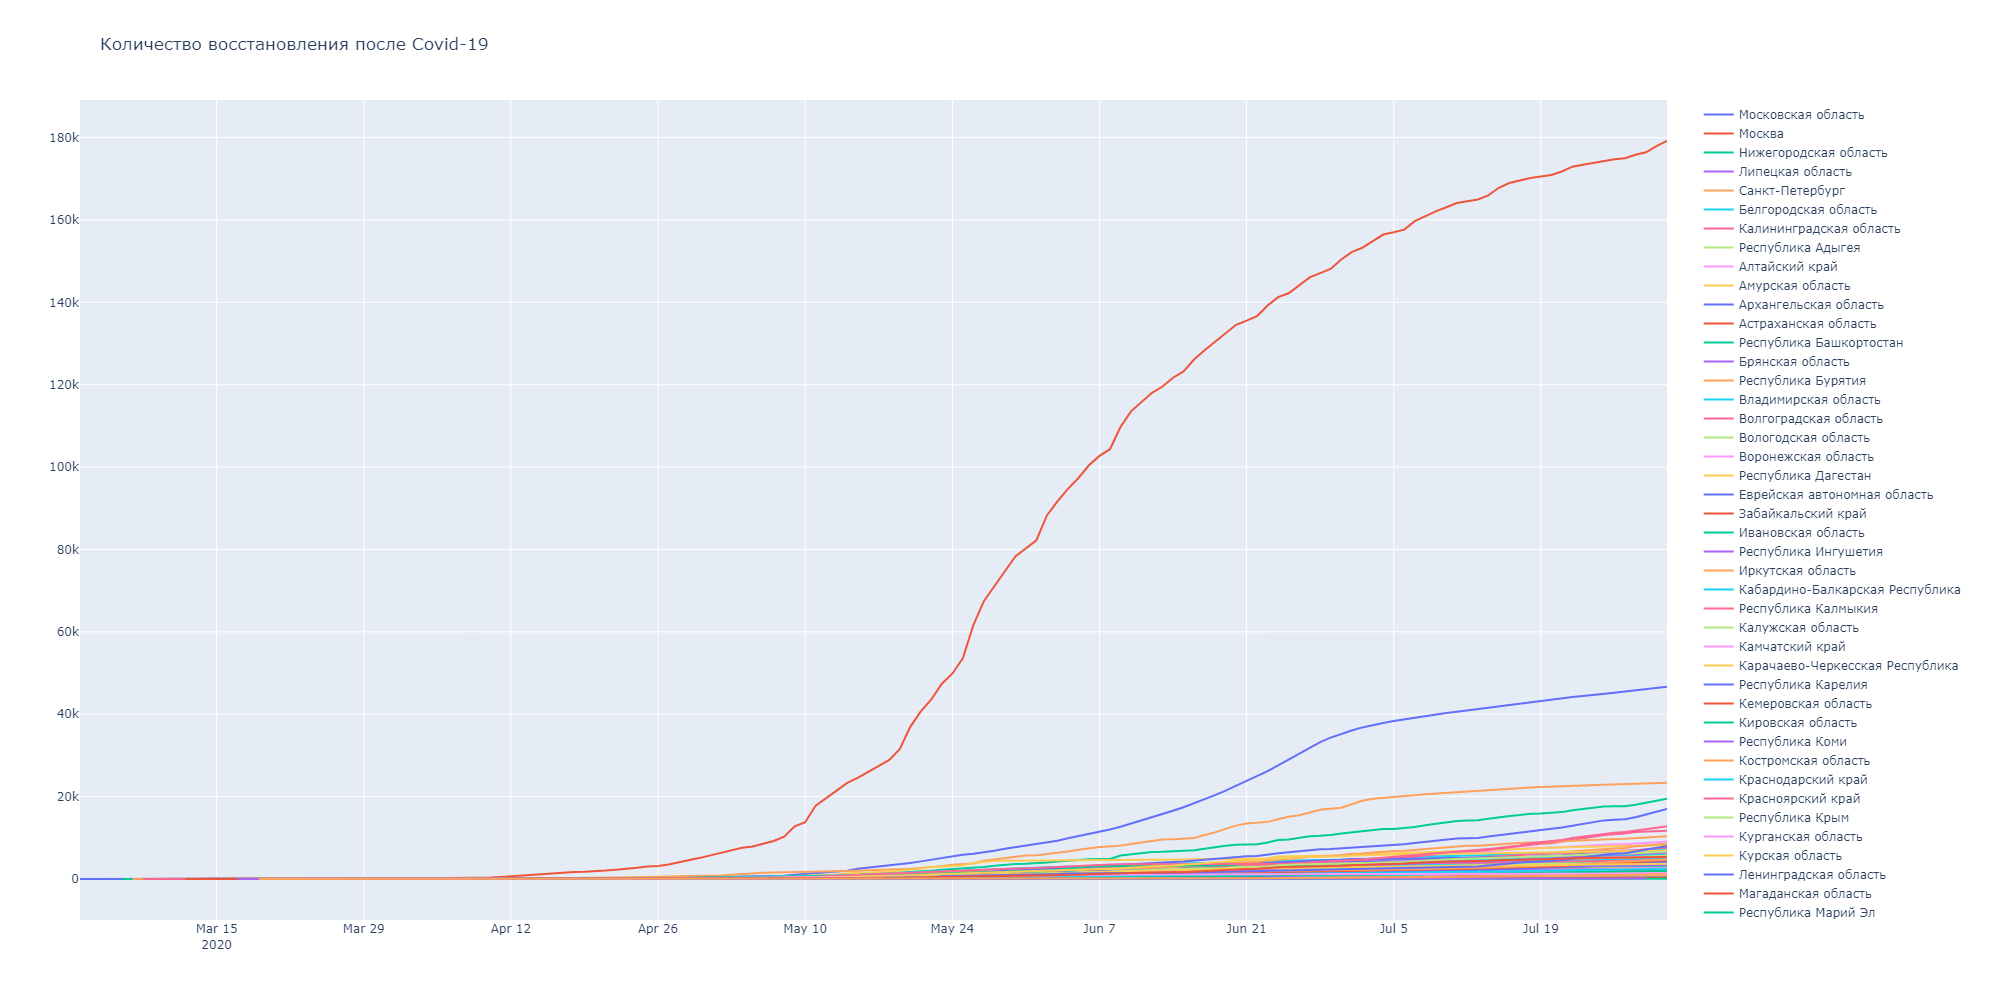

In [40]:
# Строим интерактивную диаграмму
interactive_plot(df, "Recovered", "Количество восстановления после Covid-19")

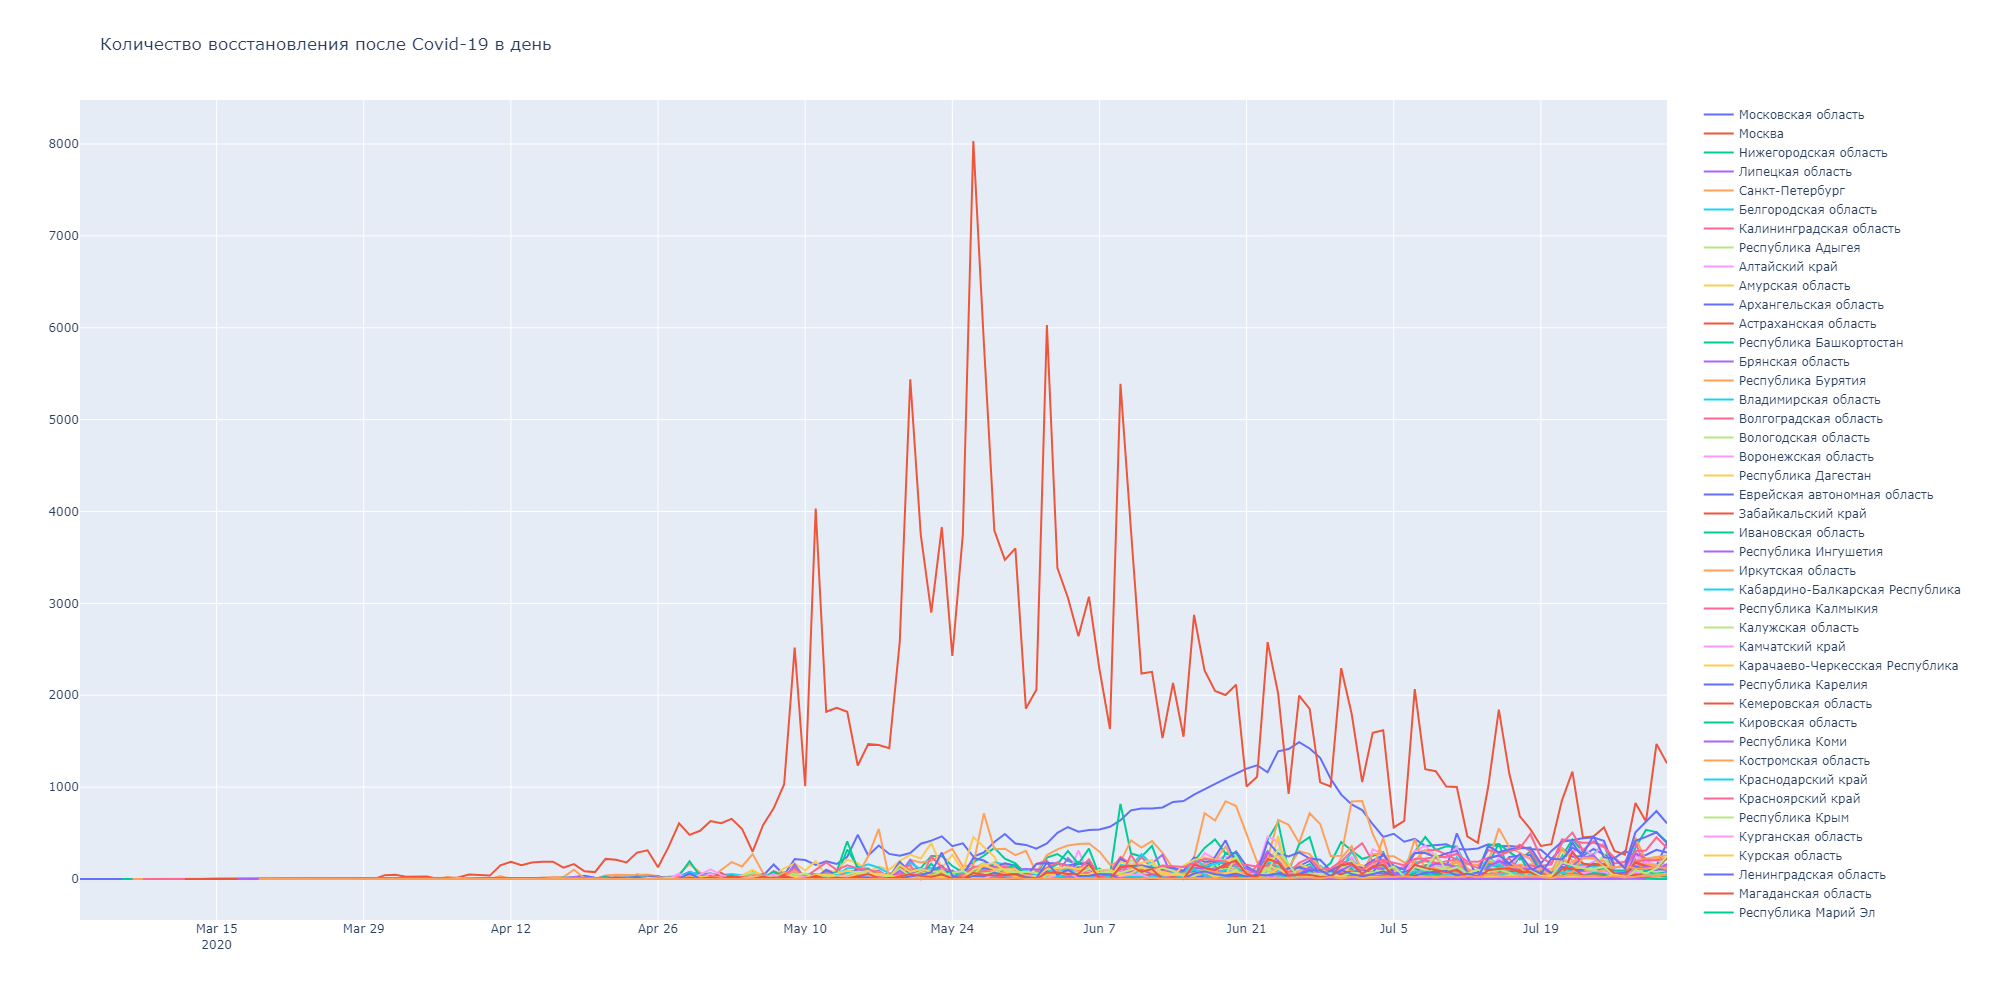

In [41]:
# Строим интерактивную диаграмму
interactive_plot(df, "Day-Recovered", "Количество восстановления после Covid-19 в день")

In [42]:
# Список уникальных городов
unique_cities = list(df['Region/City'].unique())

In [43]:
# Получаем широту и долготу города/региона по его названию

def get_lat_long(city_name):
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(city_name)
    if location == None:
        return None, None
    else:
        return location.latitude, location.longitude
    
location = [get_lat_long(x) for x in unique_cities]

In [44]:
latitude = []
longitude = []
cities = df['Region/City']
for i in range(len(cities)):
    city = cities[i]
    index = unique_cities.index(city)
    latitude.append(location[index][0])
    longitude.append(location[index][1])

In [45]:
df["geo_lat"] = latitude
df["geo_lon"] = longitude

In [46]:
df_geo = df.dropna()
df_geo['month'] = pd.DatetimeIndex(df_geo['Date']).month

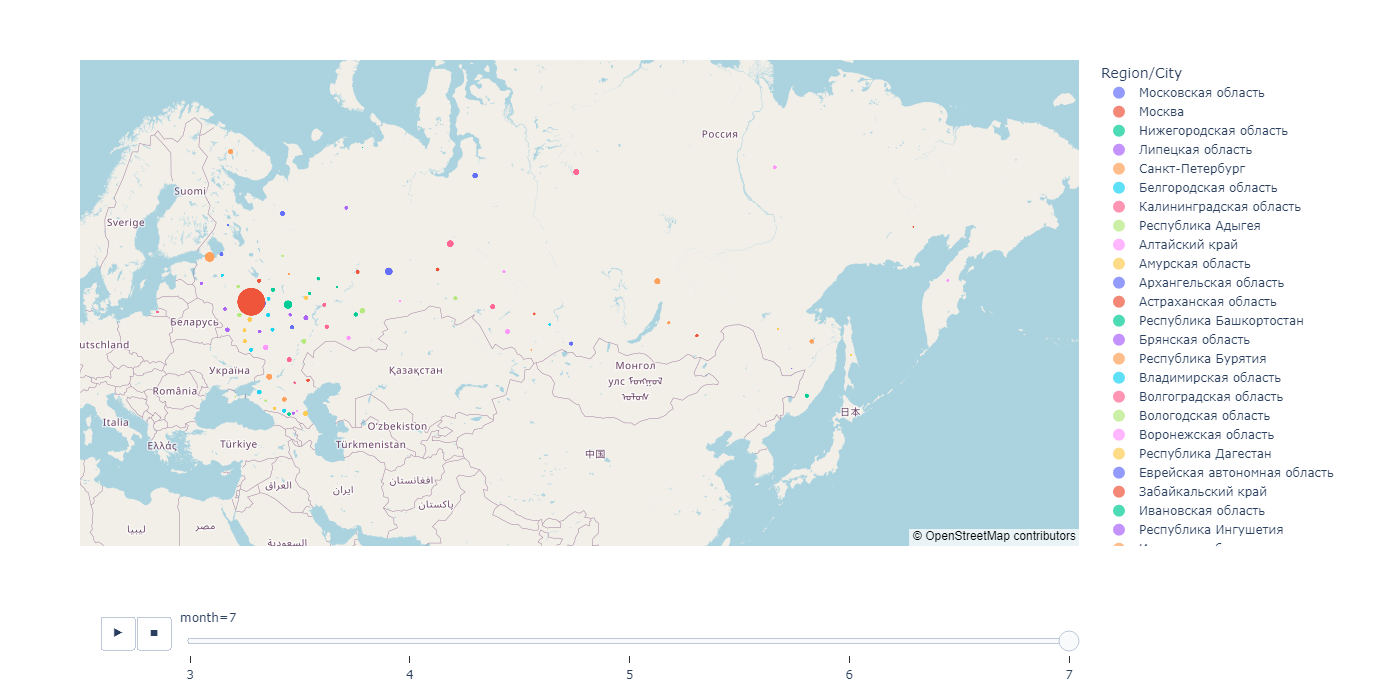

In [72]:
fig = px.scatter_mapbox(df_geo, lat='geo_lat', lon='geo_lon',
                     hover_name="Region/City", size="Confirmed", color="Region/City",
                     animation_frame="month", height=700, width=1400)

map_center = go.layout.mapbox.Center(lat=(df_geo['geo_lat'].max()+df_geo['geo_lat'].min())/2, 
                                     lon=(df_geo['geo_lon'].max()+df_geo['geo_lon'].min())/2)

fig.update_layout(
        mapbox_style="open-street-map",
        mapbox=dict(center=map_center, zoom=2)
    )

# Сохраняем анимацию в html файл
fig.write_html("map.html")

# Новая фигура
fig2 = go.Figure()

# добавить трассировку последнего кадра в fig2
for tr in fig.frames[-1].data:
    fig2.add_trace(tr)

# скопировать макет
fig2.layout = fig.layout

# скопировать кадры
fig2.frames = fig.frames

# установить последний кадр в качестве активного
fig2.layout['sliders'][0]['active'] = len(fig.frames) - 1

fig2.show("png")

### Подготавливаем данные для загрузки в модель fbprophet

In [75]:
# Для прогнозирования мы будем ориентироваться на данные по Москве.

# Получаем данные, соответствующие Москве
city = "Москва"
city_df = df[df["Region/City"] == city]

# Получим только столбцы даты и случаев
city_df = city_df[["Date", "Confirmed"]]

# сброс индекса
city_df.reset_index(inplace=True, drop=True)

# Это имена столбцов, требует fbprophet
city_df.columns = ['ds', 'y']
city_df


,ds,y
0,2020-03-06,5.0
1,2020-03-07,5.0
2,2020-03-08,5.0
3,2020-03-09,8.0
4,2020-03-10,11.0
...,...,...
143,2020-07-27,238641.0
144,2020-07-28,239315.0
145,2020-07-29,239986.0
146,2020-07-30,240664.0


In [80]:
# Разделяем данные на тестовый и тренировочный наборы данных
train , test = city_df[ city_df['ds'] <= '2020-07-16'], city_df[city_df['ds'] >  '2020-07-16']

In [81]:
train

,ds,y
0,2020-03-06,5.0
1,2020-03-07,5.0
2,2020-03-08,5.0
3,2020-03-09,8.0
4,2020-03-10,11.0
...,...,...
128,2020-07-12,229357.0
129,2020-07-13,230029.0
130,2020-07-14,230642.0
131,2020-07-15,231270.0


In [82]:
test

,ds,y
133,2020-07-17,232376.0
134,2020-07-18,232954.0
135,2020-07-19,233545.0
136,2020-07-20,234123.0
137,2020-07-21,234725.0
138,2020-07-22,235363.0
139,2020-07-23,235971.0
140,2020-07-24,236616.0
141,2020-07-25,237264.0
142,2020-07-26,237947.0


### Обучаем модель fbprophet

In [85]:
# Создаем и подгоняем прогностическую модель к обучающим данным
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\User\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [87]:
# Мы собираемся прогнозировать на 15 день, поэтому мы получаем датафрейм с датами, который включает в себя наши тренировочные даты.
future = m.make_future_dataframe(periods=15)
future

,ds
0,2020-03-06
1,2020-03-07
2,2020-03-08
3,2020-03-09
4,2020-03-10
...,...
143,2020-07-27
144,2020-07-28
145,2020-07-29
146,2020-07-30


In [88]:
# Делаем прогноз 

forecast = m.predict(future)
# 'yhat' - среднее предсказанное значение, а 'yhat_lower' и 'yhat_upper' представляют нижнюю и верхнюю
# предсказанные границы

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


C:\Users\User\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\User\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
143,2020-07-27,240511.150125,233370.882739,246459.760721
144,2020-07-28,241269.908853,233072.757085,248433.122665
145,2020-07-29,241844.326499,232562.743832,249995.483586
146,2020-07-30,242509.733687,232153.033698,251774.085192
147,2020-07-31,243202.579819,231631.938856,253504.423367


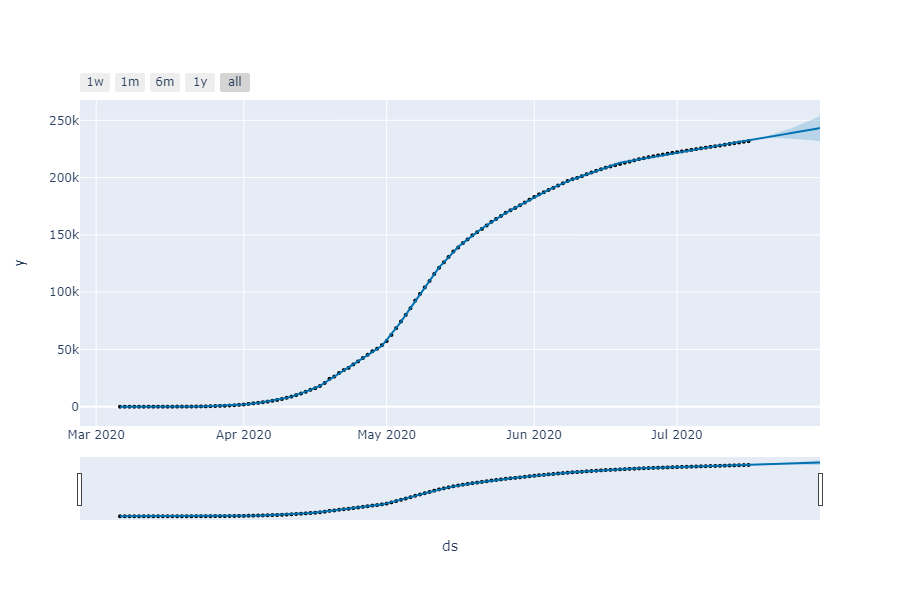

In [115]:
# Построение прогнозируемых данных

fig = plot_plotly(m, forecast)
fig.show("png")

C:\Users\User\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-118-a9ae903f3d6e>:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



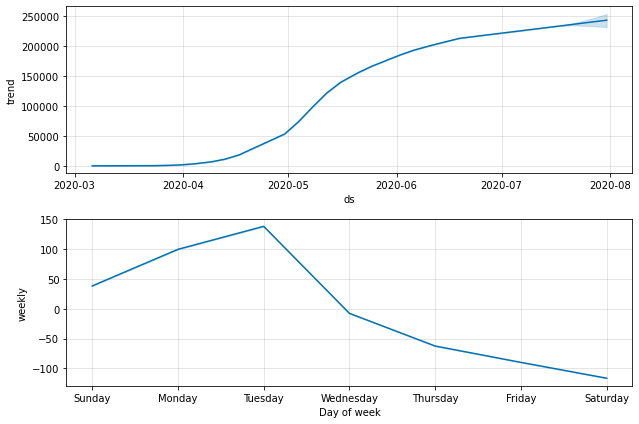

In [118]:
# Тут мы можем заметить что больший рост заболеваемости приходит на вторник
fig = m.plot_components(forecast)
fig.show("png")

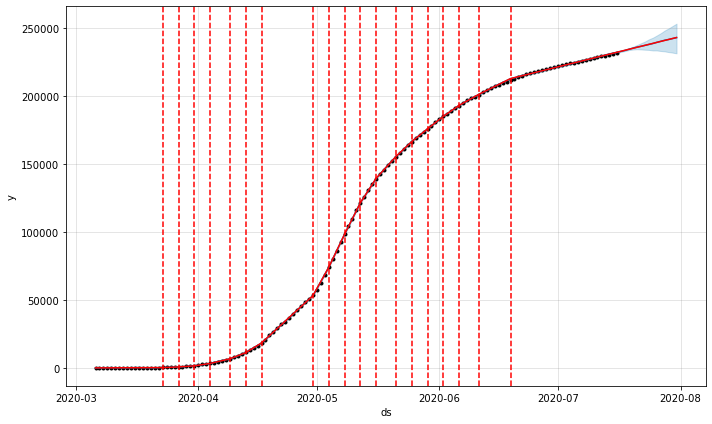

In [111]:
# Эта функция помогает нам определить изменения тренда.

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show("png")

### Оценка эффективности модели

In [92]:
# Получаем оценку эффективности модели

score = r2_score(test['y'], forecast[forecast['ds'] > '2020-07-16']['trend'])

print('Показатель R-Sqaure равен {}'.format(score))

R-Sqaure score is 0.6839446506892881


In [93]:
# Добавляем предсказанные значения к исходному датафрейму для построения графика

city_df['predicted'] = forecast['trend']

In [120]:
# Функция для построения графика прогнозируемых и исходных значений для сравнения

def interactive_plot_forecasting(df, title):
    fig = px.line(title = title)
    for i in df.columns[1:]:
        fig.add_scatter(x = df['ds'],y = df[i], name = i)
    fig.show("png")

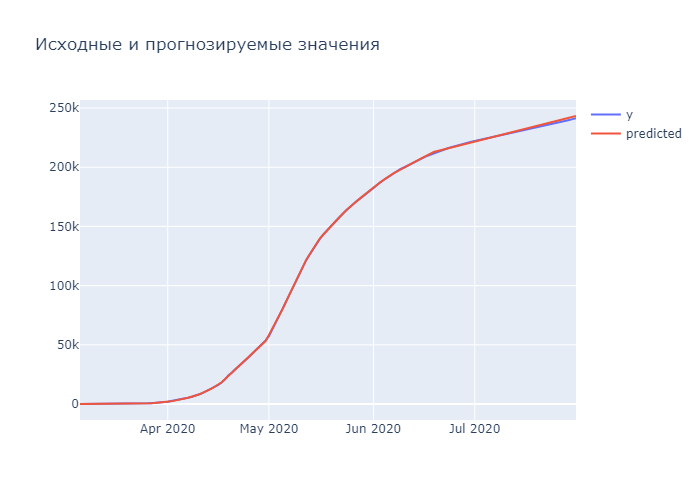

In [121]:
interactive_plot_forecasting(city_df, 'Исходные и прогнозируемые значения')